# 뗑컨 몸무게 예측 경진대회

## 패키지 import 및 데이터 전처리

In [200]:
import pandas as pd
import numpy as np

In [201]:
df = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/train.csv')

In [202]:
df.head()

,id,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g)
0,0,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,50.0,15.3,220,MALE,8.30515,-25.19017,5550
1,1,Chinstrap penguin (Pygoscelis antarctica),Dream,No,49.5,19.0,200,MALE,9.63074,-24.34684,3800
2,2,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,45.1,14.4,210,FEMALE,8.51951,-27.01854,4400
3,3,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,44.5,14.7,214,FEMALE,8.20106,-26.16524,4850
4,4,Gentoo penguin (Pygoscelis papua),Biscoe,No,49.6,16.0,225,MALE,8.38324,-26.84272,5700


In [203]:
df.rename(columns = {'Clutch Completion':'Full_Clutch', 'Culmen Length (mm)':'Culmen_Length', 
                     'Culmen Depth (mm)':'Culmen_Depth', 'Flipper Length (mm)':'Flipper_Length',
                     'Delta 15 N (o/oo)':'DeltaN', 'Delta 13 C (o/oo)':'DeltaC', 'Body Mass (g)':'Body_Mass'}, inplace = True) ## 열 이름 변경

In [204]:
df.drop('id', axis = 1, inplace = True) ## id는 필요없으니 제거 

In [205]:
df.isnull().sum()

Species           0
Island            0
Full_Clutch       0
Culmen_Length     0
Culmen_Depth      0
Flipper_Length    0
Sex               3
DeltaN            3
DeltaC            3
Body_Mass         0
dtype: int64

`-` Sex, Delta 15 N, Delta 13 C 컬럼에 결측치가 3개씩 존재한다

In [206]:
## 결측치가 있는 row들을 확인
df[df.isna().sum(axis = 1) > 0]

,Species,Island,Full_Clutch,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC,Body_Mass
6,Adelie Penguin (Pygoscelis adeliae),Torgersen,Yes,42.0,20.2,190,NaN,9.13362,-25.09368,4250
8,Adelie Penguin (Pygoscelis adeliae),Torgersen,Yes,34.1,18.1,193,NaN,NaN,NaN,3475
18,Adelie Penguin (Pygoscelis adeliae),Dream,No,39.8,19.1,184,MALE,NaN,NaN,4650
70,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,46.2,14.4,214,NaN,8.24253,-26.81540,4650
109,Adelie Penguin (Pygoscelis adeliae),Torgersen,Yes,36.6,17.8,185,FEMALE,NaN,NaN,3700


`-` 방사성 동위원소 행의 결측치에는 평균값을 넣어주자

In [207]:
df['DeltaC'].fillna(df['DeltaC'].mean(), inplace = True)
df['DeltaN'].fillna(df['DeltaN'].mean(), inplace = True)

`-` EDA를 보면 알겠지만 Species별로 몸무게가 다르다

`-` 또한 수컷과 암컷간의 차이도 꽤 있다

`-` drop해도 되지만 3개의 데이터가 유실되는 것이기에 Species와 Body_Mass를 통해 결측치에 값을 채워넣자

In [208]:
df.groupby(['Species', 'Sex']).\
agg({'Body_Mass':np.mean}).reset_index()

,Species,Sex,Body_Mass
0,Adelie Penguin (Pygoscelis adeliae),FEMALE,3448.611111
1,Adelie Penguin (Pygoscelis adeliae),MALE,4097.619048
2,Chinstrap penguin (Pygoscelis antarctica),FEMALE,3550.000000
3,Chinstrap penguin (Pygoscelis antarctica),MALE,4018.181818
4,Gentoo penguin (Pygoscelis papua),FEMALE,4707.608696
5,Gentoo penguin (Pygoscelis papua),MALE,5445.833333


`-` 6번 펭귄의 성별은 수컷, 8번은 암컷, 70번은 암컷으로 하자

In [209]:
df.loc[[6,8,70], 'Sex']= ['MALE','FEMALE', 'FEMALE']

`-` 이상으로 결측치 처리는 끝났다

In [210]:
df.isnull().sum().sum() ## 이제 결측치는 없다

0

## 모델링을 해보자

## 회귀 분석 (라벨 인코딩)

### 전처리

In [211]:
from sklearn.model_selection import train_test_split

In [212]:
dt = df.copy()

In [213]:
dt = dt.iloc[:, :-1]      ## target 제외한 데이터프레임
target = df['Body_Mass']  ## target

`-` 범주형 변수는 Species만 사용하자

In [214]:
dt2 = dt.drop(['Island', 'Full_Clutch', 'Sex'], axis = 1)

`-` 라벨인코딩을 해주자

In [215]:
dt2.head()

,Species,Culmen_Length,Culmen_Depth,Flipper_Length,DeltaN,DeltaC
0,Gentoo penguin (Pygoscelis papua),50.0,15.3,220,8.30515,-25.19017
1,Chinstrap penguin (Pygoscelis antarctica),49.5,19.0,200,9.63074,-24.34684
2,Gentoo penguin (Pygoscelis papua),45.1,14.4,210,8.51951,-27.01854
3,Gentoo penguin (Pygoscelis papua),44.5,14.7,214,8.20106,-26.16524
4,Gentoo penguin (Pygoscelis papua),49.6,16.0,225,8.38324,-26.84272


In [216]:
def labeling_penguin_name(name):
    if name == 'Gentoo penguin (Pygoscelis papua)':
        new = 2
    elif name == 'Adelie Penguin (Pygoscelis adeliae)':
        new = 1
    else:
        new = 0
    return new

In [217]:
dt2['Species_Label'] = list(map(labeling_penguin_name, dt2['Species']))

In [218]:
dt2.drop('Species', axis = 1, inplace = True)
dt2.head()

,Culmen_Length,Culmen_Depth,Flipper_Length,DeltaN,DeltaC,Species_Label
0,50.0,15.3,220,8.30515,-25.19017,2
1,49.5,19.0,200,9.63074,-24.34684,0
2,45.1,14.4,210,8.51951,-27.01854,2
3,44.5,14.7,214,8.20106,-26.16524,2
4,49.6,16.0,225,8.38324,-26.84272,2


In [219]:
x_train, x_valid, y_train, y_valid = train_test_split(dt2, target, test_size = 0.2, shuffle = True,
                                                      stratify = dt2['Species_Label'], random_state = 21)
## 종의 비율이 train, valid 비슷하도록 세팅함

`-` 위의 split한 데이터프레임을 reset_index 하게 되면 기존의 인덱스번호가 초기화됨을 잊지말자 

`-` 우선 간단하게 회귀 모형을 만들어보자

`-` 변수별 상관계수가 높으므로 전체 변수를 설정하여 모형을 만들고 유의하지 않은 변수 하나씩 제거하자

### 모델 선택

In [220]:
import statsmodels.formula.api as smf

In [221]:
tmp = pd.concat([x_train, y_train], axis = 1)
tmp.head()

,Culmen_Length,Culmen_Depth,Flipper_Length,DeltaN,DeltaC,Species_Label,Body_Mass
54,51.4,19.0,201,9.43782,-24.36202,0,3950
5,51.1,16.5,225,8.20660,-26.36863,2,5250
107,46.8,16.5,189,9.65061,-24.48153,0,3650
52,42.9,17.6,196,8.63259,-26.23027,1,4700
108,49.0,19.6,212,9.34089,-24.45189,0,4300


In [222]:
result = smf.ols(formula = 'Body_Mass ~ Culmen_Length +\
                 Culmen_Depth + Flipper_Length +\
                 DeltaN + DeltaC + Species_Label', data = tmp).fit()

In [223]:
# result.summary()

`-` DeltaN 변수가 가장 유의하지 않게 나온다

`-` 이를 제거하고 다시 회귀분석을 실시하자

In [224]:
result2 = smf.ols(formula = 'Body_Mass ~ Culmen_Length +\
                 Culmen_Depth + Flipper_Length +\
                 + DeltaC + Species_Label', data = tmp).fit()

In [225]:
# result2.summary()

`-` DeltaC 변수가 유의하지 않게 나온다

`-` 이를 제거하고 다시 회귀분석을 실시하자

In [226]:
result3 = smf.ols(formula = 'Body_Mass ~ Culmen_Length +\
                 Culmen_Depth + Flipper_Length +\
                 + Species_Label', data = tmp).fit()

In [227]:
# result3.summary()

`-` 더 이상 유의하지 않은 변수는 없다

`-` x_valid와 y_valid를 통해 모형을 평가하자

### 모델 평가

In [228]:
def RMSE(real, predict):
    return np.sqrt(np.mean(np.square(real - predict)))

In [229]:
def mass_predict(dt):
    return -4514.4208 + dt['Culmen_Length']*51.5544 + dt['Culmen_Depth']*120.1742 + dt['Flipper_Length']*18.1086 + dt['Species_Label']*680.6902

In [230]:
predict_y = mass_predict(x_valid)
predict_y[:6]

109    3542.35220
18     3845.44414
63     3906.37042
41     4248.07078
24     3680.90772
19     3859.05706
dtype: float64

In [231]:
# 실제 정답 값을 준비
real_answer = y_valid.copy()

# 정답과 예측 값을 함수에 넣어 결과를 확인
error = RMSE(real_answer, predict_y)

print(f'이 방정식의 평균 에러는 {error:.2f} 입니다')

이 방정식의 평균 에러는 331.42 입니다


`-` 모델 평가를 마쳤다

`-` test파일을 불러와 예측하고 이를 제출하자

### test 데이터 예측

In [232]:
test = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/test.csv')
test.head()

,id,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
0,0,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,52.0,20.7,210.0,MALE,9.43146,-24.68440
1,1,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,55.9,17.0,228.0,MALE,8.31180,-26.35425
2,2,Adelie Penguin (Pygoscelis adeliae),Dream,Yes,38.9,18.8,190.0,FEMALE,8.36936,-26.11199
3,3,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,45.2,16.6,191.0,FEMALE,9.62357,-24.78984
4,4,Adelie Penguin (Pygoscelis adeliae),Biscoe,No,37.9,18.6,172.0,FEMALE,8.38404,-25.19837


In [233]:
test.isnull().sum()

id                     0
Species                0
Island                 0
Clutch Completion      0
Culmen Length (mm)     0
Culmen Depth (mm)      0
Flipper Length (mm)    0
Sex                    6
Delta 15 N (o/oo)      9
Delta 13 C (o/oo)      8
dtype: int64

`-` test 데이터에 NA가 존재하지만 어짜피 사용하지 않는 변수이므로 무시해도 된다

In [234]:
test.rename(columns = {'Clutch Completion':'Full_Clutch', 'Culmen Length (mm)':'Culmen_Length', 
                     'Culmen Depth (mm)':'Culmen_Depth', 'Flipper Length (mm)':'Flipper_Length',
                     'Delta 15 N (o/oo)':'DeltaN', 'Delta 13 C (o/oo)':'DeltaC', 'Body Mass (g)':'Body_Mass'}, inplace = True) ## 열 이름 변경

In [235]:
test['Species_Label'] = list(map(labeling_penguin_name, test['Species']))

In [236]:
test.head()

,id,Species,Island,Full_Clutch,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC,Species_Label
0,0,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,52.0,20.7,210.0,MALE,9.43146,-24.68440,0
1,1,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,55.9,17.0,228.0,MALE,8.31180,-26.35425,2
2,2,Adelie Penguin (Pygoscelis adeliae),Dream,Yes,38.9,18.8,190.0,FEMALE,8.36936,-26.11199,1
3,3,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,45.2,16.6,191.0,FEMALE,9.62357,-24.78984,0
4,4,Adelie Penguin (Pygoscelis adeliae),Biscoe,No,37.9,18.6,172.0,FEMALE,8.38404,-25.19837,1


In [237]:
# 예측을 진행
predict_test = mass_predict(test)

# 예측 결과를 확인
predict_test[:6]

0    4456.81994
1    5900.57276
2    3871.64452
3    3269.47240
4    3470.10048
5    4149.33944
dtype: float64

### dacon 대회에 제출하기

In [42]:
# 제출용 sample 파일을 불러옴
submission = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/sample_submission.csv')
submission.head()

,id,Body Mass (g)
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [43]:
# 위에서 구한 예측값을 그대로 넣음
submission['Body Mass (g)'] = predict_test

# 데이터가 잘 들어갔는지 확인
submission.head()

,id,Body Mass (g)
0,0,4456.81994
1,1,5900.57276
2,2,3871.64452
3,3,3269.47240
4,4,3470.10048


In [370]:
# submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/submission.csv', index = False)

`-` 점수는 329.2286192974

## 회귀 분석 (원핫인코딩) + 정규화

`-` 라벨 인코딩과 원핫인코딩 모델간의 성능차이를 확인해보자

### 전처리

`-` Species 변수를 수치형으로 변경해주기 위해 원핫인코딩 해주자

In [238]:
dt3 = dt.drop(['Island', 'Full_Clutch', 'Sex'], axis = 1)

In [239]:
dt3.head()

,Species,Culmen_Length,Culmen_Depth,Flipper_Length,DeltaN,DeltaC
0,Gentoo penguin (Pygoscelis papua),50.0,15.3,220,8.30515,-25.19017
1,Chinstrap penguin (Pygoscelis antarctica),49.5,19.0,200,9.63074,-24.34684
2,Gentoo penguin (Pygoscelis papua),45.1,14.4,210,8.51951,-27.01854
3,Gentoo penguin (Pygoscelis papua),44.5,14.7,214,8.20106,-26.16524
4,Gentoo penguin (Pygoscelis papua),49.6,16.0,225,8.38324,-26.84272


In [240]:
dummy = pd.get_dummies(dt3['Species'])
dummy.head()

,Adelie Penguin (Pygoscelis adeliae),Chinstrap penguin (Pygoscelis antarctica),Gentoo penguin (Pygoscelis papua)
0,0,0,1
1,0,1,0
2,0,0,1
3,0,0,1
4,0,0,1


In [241]:
dt3 = pd.concat([dt3, dummy], axis = 1)

In [242]:
dt3.rename(columns = {'Adelie Penguin (Pygoscelis adeliae)':'Adelie',
                          'Chinstrap penguin (Pygoscelis antarctica)':'Chinstrap',
                          'Gentoo penguin (Pygoscelis papua)':'Gentoo'}, inplace = True)

In [243]:
dt3.head()

,Species,Culmen_Length,Culmen_Depth,Flipper_Length,DeltaN,DeltaC,Adelie,Chinstrap,Gentoo
0,Gentoo penguin (Pygoscelis papua),50.0,15.3,220,8.30515,-25.19017,0,0,1
1,Chinstrap penguin (Pygoscelis antarctica),49.5,19.0,200,9.63074,-24.34684,0,1,0
2,Gentoo penguin (Pygoscelis papua),45.1,14.4,210,8.51951,-27.01854,0,0,1
3,Gentoo penguin (Pygoscelis papua),44.5,14.7,214,8.20106,-26.16524,0,0,1
4,Gentoo penguin (Pygoscelis papua),49.6,16.0,225,8.38324,-26.84272,0,0,1


In [52]:
x_train, x_valid, y_train, y_valid = train_test_split(dt3, target, test_size = 0.2, shuffle = True,
                                                      stratify = dt3['Species'], random_state = 21)
## 종의 비율이 train, valid 비슷하도록 세팅함

In [53]:
x_train.drop('Species', axis = 1, inplace = True)
x_valid.drop('Species', axis = 1, inplace = True)

`-` 정규화를 시켜주자(최대값 $1$, 최소값 $-1$)

`-` 표준화는 회귀보단 분류에 적합하고 정규화는 분류보단 회귀에 적합하다고 한다

`-` 둘다 이상점에 민감하다

`-` 그런데 생각해보니 test 데이터셋은 스케일링을 못함

`-` 그런데 회귀모형은 스케일링된 계수에 의해 추정됨

`-` 예측하려면 스케일링을 하면 안되겠음

`-` 어짜피 회귀모형은 스케일링 하든 안하든 똑같다

`-` train셋에서 사용한 스케일링을 그래도 test셋에다 사용하면 된다(오차는 있지만...)

In [54]:
from sklearn.preprocessing import MinMaxScaler

## 스케일러 생성
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(x_train)

## 트레인집합 정규화
x_train_scaled = minmax_scaler.transform(x_train)
x_train_scaled_df = pd.DataFrame(data = x_train_scaled, columns = x_train.columns)

## 테스트집합 정규화
x_valid_scaled = minmax_scaler.transform(x_valid) ## x_train에서 학습한 정규화방식을 그대로 x_valid에 적용
x_valid_scaled_df = pd.DataFrame(data = x_valid_scaled, columns = x_valid.columns)

In [55]:
x_train_scaled_df['Body_Mass'] = list(y_train)

In [62]:
x_train_scaled_df.head()

,Culmen_Length,Culmen_Depth,Flipper_Length,DeltaN,DeltaC,Adelie,Chinstrap,Gentoo,Body_Mass
0,0.745370,0.354430,0.894737,0.313817,0.061629,0.0,0.0,1.0,5700
1,0.143519,0.582278,0.192982,0.461899,0.454099,1.0,0.0,0.0,3700
2,0.620370,0.430380,0.315789,0.908262,0.799610,0.0,1.0,0.0,2700
3,0.000000,0.734177,0.280702,0.107148,0.135894,1.0,0.0,0.0,3600
4,0.527778,0.012658,0.684211,0.342410,0.042799,0.0,0.0,1.0,5100


`-` 정규화가 잘 되었다

### 모델 선택

In [63]:
rslt = smf.ols(formula = 'Body_Mass ~ Culmen_Length +\
               Culmen_Depth + Flipper_Length +\
               Adelie + Chinstrap + Gentoo +\
               DeltaN + DeltaC', data = x_train_scaled_df).fit()

In [72]:
# rslt.summary()

`-` DeltaN 변수가 가장 유의하지 않으니 제거하자 (Species 관련 변수는 예외)

`-` Chinstrap feature는 제거해도 변화가 없다

In [66]:
rslt2 = smf.ols(formula = 'Body_Mass ~ Culmen_Length +\
               Culmen_Depth + Flipper_Length +\
               Adelie + Chinstrap + Gentoo +\
               DeltaC', data = x_train_scaled_df).fit()

In [95]:
# rslt2.summary()

`-` 유의하지 않은 변수를 제거하니 조정된 결정계수가 올라간 것을 확인할 수 있다

`-` 이번에는 DeltaC 변수가 가장 유의하지 않으니 제거하자

In [68]:
rslt3 = smf.ols(formula = 'Body_Mass ~ Culmen_Length +\
               Culmen_Depth + Flipper_Length +\
               Adelie + Chinstrap + Gentoo', data = x_train_scaled_df).fit()

In [94]:
# rslt3.summary()

`-` 더 이상 유의하지 않은 변수는 없다

`-` 테스트셋을 통해 모델을 평가하자

### 모델 평가

In [76]:
pred_df = pd.DataFrame(rslt3.params).reset_index().rename(columns = {'index':'var_name', 0:'coefficient'})
pred_df

,var_name,coefficient
0,Intercept,2012.844563
1,Culmen_Length,1047.559568
2,Culmen_Depth,1036.488311
3,Flipper_Length,877.162091
4,Adelie,625.367329
5,Chinstrap,-50.210463
6,Gentoo,1437.687698


In [77]:
def mass_predict2(df):
    y_predict = np.array(list(pred_df.query('var_name == "Intercept"')['coefficient']) * len(df))
    for col in df.columns:
        if col in pred_df.set_index('var_name').T.columns:
            y_predict += (np.array(df[col] * pred_df.query('var_name == @col')['coefficient'].to_numpy()))
    return y_predict

In [83]:
predict_y = mass_predict2(x_valid_scaled_df) ## 정규화된 valid 셋을 input한다
predict_y[:6]

array([3670.68414525, 3703.22495284, 3731.03157442, 5234.15878086,
       4164.99267427, 3347.76625386])

In [84]:
# 실제 정답 값을 준비
real_answer = y_valid.copy()

# 정답과 예측 값을 함수에 넣어 결과를 확인
error = RMSE(real_answer, predict_y)

print(f'이 방정식의 평균 에러는 {error:.2f} 입니다')

이 방정식의 평균 에러는 316.19 입니다


`-` 모델 평가를 마쳤다

`-` test파일을 불러와 예측하고 이를 제출하자

### test 데이터 예측

In [96]:
test = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/test.csv')
test.head()

,id,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
0,0,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,52.0,20.7,210.0,MALE,9.43146,-24.68440
1,1,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,55.9,17.0,228.0,MALE,8.31180,-26.35425
2,2,Adelie Penguin (Pygoscelis adeliae),Dream,Yes,38.9,18.8,190.0,FEMALE,8.36936,-26.11199
3,3,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,45.2,16.6,191.0,FEMALE,9.62357,-24.78984
4,4,Adelie Penguin (Pygoscelis adeliae),Biscoe,No,37.9,18.6,172.0,FEMALE,8.38404,-25.19837


In [98]:
test.rename(columns = {'Clutch Completion':'Full_Clutch', 'Culmen Length (mm)':'Culmen_Length', 
                     'Culmen Depth (mm)':'Culmen_Depth', 'Flipper Length (mm)':'Flipper_Length',
                     'Delta 15 N (o/oo)':'DeltaN', 'Delta 13 C (o/oo)':'DeltaC', 'Body Mass (g)':'Body_Mass'}, inplace = True) ## 열 이름 변경

In [97]:
test.isnull().sum()

id                     0
Species                0
Island                 0
Clutch Completion      0
Culmen Length (mm)     0
Culmen Depth (mm)      0
Flipper Length (mm)    0
Sex                    6
Delta 15 N (o/oo)      9
Delta 13 C (o/oo)      8
dtype: int64

`-` test 데이터에 NA가 존재하지만 어짜피 사용하지 않는 변수이므로 무시해도 된다

`-` 테스트 데이터셋도 Species에 대해 원핫인코딩을 하자

In [110]:
test2 = test.copy()

In [111]:
dummy = pd.get_dummies(test2['Species'])

In [112]:
test2 = pd.concat([test2, dummy], axis = 1)

In [113]:
test2.rename(columns = {'Adelie Penguin (Pygoscelis adeliae)':'Adelie',
                          'Chinstrap penguin (Pygoscelis antarctica)':'Chinstrap',
                          'Gentoo penguin (Pygoscelis papua)':'Gentoo'}, inplace = True)

In [114]:
test2.drop(['id', 'Species', 'Island', 'Full_Clutch', 'Sex'], axis = 1, inplace = True) 

In [115]:
test2.head()

,Culmen_Length,Culmen_Depth,Flipper_Length,DeltaN,DeltaC,Adelie,Chinstrap,Gentoo
0,52.0,20.7,210.0,9.43146,-24.68440,0,1,0
1,55.9,17.0,228.0,8.31180,-26.35425,0,0,1
2,38.9,18.8,190.0,8.36936,-26.11199,1,0,0
3,45.2,16.6,191.0,9.62357,-24.78984,0,1,0
4,37.9,18.6,172.0,8.38404,-25.19837,1,0,0


`-` test 셋도 정규화를 해주자

In [116]:
## 테스트집합 정규화
test2_scaled = minmax_scaler.transform(test2) ## x_train에서 학습한 정규화방식을 그대로 x_valid에 적용

In [119]:
test2_scaled_df = pd.DataFrame(data = test2_scaled, columns = test2.columns)

In [121]:
test2_scaled_df.head()

,Culmen_Length,Culmen_Depth,Flipper_Length,DeltaN,DeltaC,Adelie,Chinstrap,Gentoo
0,0.856481,0.949367,0.631579,0.751809,0.818170,0.0,1.0,0.0
1,1.037037,0.481013,0.947368,0.283967,0.232849,0.0,0.0,1.0
2,0.250000,0.708861,0.280702,0.308018,0.317767,1.0,0.0,0.0
3,0.541667,0.430380,0.298246,0.832081,0.781211,0.0,1.0,0.0
4,0.203704,0.683544,-0.035088,0.314152,0.638011,1.0,0.0,0.0


In [122]:
# 예측을 진행
predict_test = mass_predict2(test2_scaled_df)

# 예측 결과를 확인
predict_test[:6]

array([4397.85447076, 5866.44999422, 3881.04861347, 3237.7555226 ,
       3529.31171997, 4113.66770178])

### dacon 대회에 제출하기

In [124]:
# 제출용 sample 파일을 불러옴
submission = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/sample_submission.csv')

In [125]:
# 위에서 구한 예측값을 그대로 넣음
submission['Body Mass (g)'] = predict_test

In [126]:
submission.head()

,id,Body Mass (g)
0,0,4397.854471
1,1,5866.449994
2,2,3881.048613
3,3,3237.755523
4,4,3529.311720


In [127]:
# submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/submission2.csv', index = False)

`-` 점수는 341.1752753861

## 회귀 분석 (라벨 인코딩) + 뒤로부터 제거하는 방법 + 정규화

### 전처리

`-` 위에서는 범주형 변수를 Species만 사용했는데 이번에는 모든 변수를 사용하자

In [244]:
dt4 = dt.copy() 

In [245]:
dt4.head()

,Species,Island,Full_Clutch,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC
0,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,50.0,15.3,220,MALE,8.30515,-25.19017
1,Chinstrap penguin (Pygoscelis antarctica),Dream,No,49.5,19.0,200,MALE,9.63074,-24.34684
2,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,45.1,14.4,210,FEMALE,8.51951,-27.01854
3,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,44.5,14.7,214,FEMALE,8.20106,-26.16524
4,Gentoo penguin (Pygoscelis papua),Biscoe,No,49.6,16.0,225,MALE,8.38324,-26.84272


`-` 범주형 변수에 라벨인코딩을 해주자

In [246]:
from sklearn.preprocessing import LabelEncoder

for col in dt4.columns:
    if dt4.dtypes[col] == 'O':
        encoder = LabelEncoder()
        encoder.fit(dt4[col])
        labels = encoder.transform(dt4[col])
        dt4[col] = list(labels) 

In [247]:
dt4.head()

,Species,Island,Full_Clutch,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC
0,2,0,1,50.0,15.3,220,1,8.30515,-25.19017
1,1,1,0,49.5,19.0,200,1,9.63074,-24.34684
2,2,0,1,45.1,14.4,210,0,8.51951,-27.01854
3,2,0,1,44.5,14.7,214,0,8.20106,-26.16524
4,2,0,0,49.6,16.0,225,1,8.38324,-26.84272


`-` 라벨 인코딩이 잘 되었다

In [248]:
x_train, x_valid, y_train, y_valid = train_test_split(dt4, target, test_size = 0.2, shuffle = True,
                                                      stratify = dt4['Species'], random_state = 21)
## 종의 비율이 train, valid 비슷하도록 세팅함

`-` 위의 split한 데이터프레임을 reset_index 하게 되면 기존의 인덱스번호가 초기화됨을 잊지말자 

`-` 우선 간단하게 회귀 모형을 만들어보자

`-` 변수별 상관계수가 높으므로 전체 변수를 설정하여 모형을 만들고 유의하지 않은 변수 하나씩 제거하자

`-` 그 전에 정규화를 해주자

In [249]:
## 스케일러 생성
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(x_train)

## 트레인집합 정규화
x_train_scaled = minmax_scaler.transform(x_train)
x_train_scaled_df = pd.DataFrame(data = x_train_scaled, columns = x_train.columns)

## 테스트집합 정규화
x_valid_scaled = minmax_scaler.transform(x_valid) ## x_train에서 학습한 정규화방식을 그대로 x_valid에 적용
x_valid_scaled_df = pd.DataFrame(data = x_valid_scaled, columns = x_valid.columns)

In [250]:
x_train_scaled_df['Body_Mass'] = list(y_train)

### 모델 선택

In [261]:
x_train_scaled_df.head()

,Species,Island,Full_Clutch,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC,Body_Mass
0,1.0,0.0,0.0,0.745370,0.354430,0.894737,1.0,0.313817,0.061629,5700
1,0.0,1.0,1.0,0.143519,0.582278,0.192982,0.0,0.461899,0.454099,3700
2,0.5,0.5,0.0,0.620370,0.430380,0.315789,0.0,0.908262,0.799610,2700
3,0.0,1.0,1.0,0.000000,0.734177,0.280702,0.0,0.107148,0.135894,3600
4,1.0,0.0,1.0,0.527778,0.012658,0.684211,0.0,0.342410,0.042799,5100


In [138]:
rst = smf.ols(formula = 'Body_Mass ~ Culmen_Length +\
                 Culmen_Depth + Flipper_Length +\
                 DeltaN + DeltaC + Species +\
                 Island + Full_Clutch + Sex', data = x_train_scaled_df).fit()

In [144]:
# rst.summary()

`-` Full_Clutch 변수가 가장 유의하지 않게 나온다

`-` 또한 정규화로 인해 다중공선성도 사라졌다

`-` (원핫인코딩) + (정규화) 에서는 정규화를 해도 다중공선성이 있었는데 왜 그런지는 더 알아봐야 될 것 같다

`-` 내 생각 : 원핫인코딩이 문제(피쳐 개수가 늘어남), 라벨인코딩을 해줘야 한다

`-` 원핫인코딩으로 Species를 3개로 나눴는데 EDA를 보면 Species간에 구분이 확실한 것을 알 수 있음 ---> 이 때문인 듯 

`-` 아무튼 Full_Clutch 변수를 제거하고 다시 회귀분석을 실시하자

In [142]:
rst2 = smf.ols(formula = 'Body_Mass ~ Culmen_Length +\
                 Culmen_Depth + Flipper_Length +\
                 DeltaN + DeltaC + Species +\
                 Island + Sex', data = x_train_scaled_df).fit()

In [145]:
# rst2.summary()

`-` Culmen_Length 변수가 가장 유의하지 않게 나온다

`-` 이를 제거하고 다시 회귀분석을 실시하자

In [146]:
rst3 = smf.ols(formula = 'Body_Mass ~ \
                 Culmen_Depth + Flipper_Length +\
                 DeltaN + DeltaC + Species +\
                 Island + Sex', data = x_train_scaled_df).fit()

In [152]:
# rst3.summary()

`-` Culmen_Depth 변수가 가장 유의하지 않게 나온다

`-` 이를 제거하고 다시 회귀분석을 실시하자

In [149]:
rst4 = smf.ols(formula = 'Body_Mass ~ Flipper_Length +\
                 DeltaN + DeltaC + Species +\
                 Island + Sex', data = x_train_scaled_df).fit()

In [155]:
# rst4.summary()

`-` DeltaC 변수가 가장 유의하지 않게 나온다

`-` 이를 제거하고 다시 회귀분석을 실시하자

In [262]:
rst5 = smf.ols(formula = 'Body_Mass ~ Flipper_Length +\
                 DeltaN + Species +\
                 Island + Sex', data = x_train_scaled_df).fit()

In [166]:
# rst5.summary()

`-` Species 변수가 가장 유의하지 않게 나온다

`-` EDA를 통해 Species와 Island에 의해 클러스터링됨을 확인했다

`-` 예상외로 Species 변수보다 Island 변수가 더 유의하게 나온다

`-` Species 변수를 제거하고 다시 회귀분석을 실시하자

In [271]:
rst6 = smf.ols(formula = 'Body_Mass ~ Flipper_Length +\
                 DeltaN + Island + Sex', data = x_train_scaled_df).fit()

In [273]:
# rst6.summary()

`-` 유의하지 않은 변수가 없다

`-` 그런데 오히려 결정계수가 떨어졌다

`-` 평가지표가 RMSE인 만큼 좋지 않은 결과이다

`-` Species 변수는 제거하지 않겠다

`-` 최종 모형은 rst5를 사용하자

In [268]:
rst7 = smf.ols(formula = 'Body_Mass ~ Flipper_Length +\
                 DeltaN + Species + Sex', data = x_train_scaled_df).fit()

In [274]:
# rst7.summary()

`-` 대신에 Island 변수를 제거해봤다

### 잔차와 적합치 산점도

In [26]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'fitted vs residual')

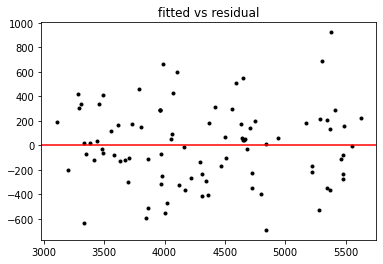

In [263]:
plt.plot(rst5.fittedvalues, rst5.resid, '.k')
plt.axhline(0, 0.0, 1.0, color = 'red')
plt.title('fitted vs residual')

`-` 예쁘게 잘 나왔다

<AxesSubplot:>

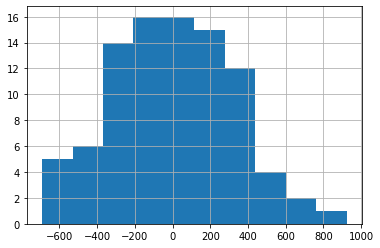

In [279]:
rst5.resid.hist()

`-` 잔차가 종모양을 띈다

`-` Island를 제거하고 Species를 선택한 모형(rst7)에 대한 잔차와 적합치 그림

Text(0.5, 1.0, 'fitted vs residual')

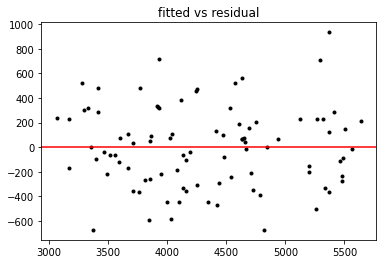

In [275]:
plt.plot(rst7.fittedvalues, rst7.resid, '.k')
plt.axhline(0, 0.0, 1.0, color = 'red')
plt.title('fitted vs residual')

`-` 이 역시 잘 나왔다

`-` 수평선을 기준으로 잔차가 고르게 나뉘었으며 이분산성도 없어보인다

<AxesSubplot:>

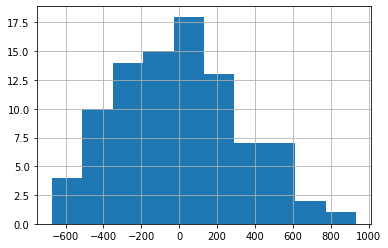

In [278]:
rst7.resid.hist()

`-` 잔차가 종모양을 띈다

### 모델 평가

In [288]:
def mass_predict_rst(df, pred_df):
    y_predict = np.array(list(pred_df.query('var_name == "Intercept"')['coefficient']) * len(df))
    for col in df.columns:
        if col in pred_df.set_index('var_name').T.columns:
            y_predict += (np.array(df[col] * pred_df.query('var_name == @col')['coefficient'].to_numpy()))
    return y_predict

In [289]:
pred_df5 = pd.DataFrame(rst5.params).reset_index().rename(columns = {'index':'var_name', 0:'coefficient'})

In [285]:
pred_df7 = pd.DataFrame(rst7.params).reset_index().rename(columns = {'index':'var_name', 0:'coefficient'})

In [290]:
predict_y5 = mass_predict_rst(x_valid_scaled_df, pred_df5)
predict_y5[:6]

array([3504.2814836 , 4160.39385879, 3502.54533651, 5345.76197534,
       3830.45929757, 3380.66628828])

In [291]:
predict_y7 = mass_predict_rst(x_valid_scaled_df, pred_df7)
predict_y7[:6]

array([3545.17528648, 4185.92493692, 3651.95784854, 5331.24476676,
       3977.18920337, 3185.64960478])

In [292]:
# 실제 정답 값을 준비
real_answer = y_valid.copy()

# 정답과 예측 값을 함수에 넣어 결과를 확인
error = RMSE(real_answer, predict_y5)

print(f'이 방정식의 평균 에러는 {error:.2f} 입니다')

이 방정식의 평균 에러는 246.55 입니다


In [293]:
# 정답과 예측 값을 함수에 넣어 결과를 확인
error = RMSE(real_answer, predict_y7)

print(f'이 방정식의 평균 에러는 {error:.2f} 입니다')

이 방정식의 평균 에러는 238.04 입니다


`-` 모델 평가를 마쳤다

`-` test파일을 불러와 예측하고 이를 제출하자

### test 데이터 예측

In [300]:
test = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/test.csv')
test.head()

,id,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
0,0,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,52.0,20.7,210.0,MALE,9.43146,-24.68440
1,1,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,55.9,17.0,228.0,MALE,8.31180,-26.35425
2,2,Adelie Penguin (Pygoscelis adeliae),Dream,Yes,38.9,18.8,190.0,FEMALE,8.36936,-26.11199
3,3,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,45.2,16.6,191.0,FEMALE,9.62357,-24.78984
4,4,Adelie Penguin (Pygoscelis adeliae),Biscoe,No,37.9,18.6,172.0,FEMALE,8.38404,-25.19837


In [301]:
test.isnull().sum()

id                     0
Species                0
Island                 0
Clutch Completion      0
Culmen Length (mm)     0
Culmen Depth (mm)      0
Flipper Length (mm)    0
Sex                    6
Delta 15 N (o/oo)      9
Delta 13 C (o/oo)      8
dtype: int64

`-` test 데이터에 NA가 존재한다

`-` 위에서 train 데이터의 NA를 처리하는 방식과 비슷하게 처리하자

`-` 방사성 동위원소 값은 train 데이터의 각각의 동위원소 피쳐 평균으로 대체한다

In [302]:
test['Delta 15 N (o/oo)'].fillna(dt['DeltaN'].mean(), inplace = True)
test['Delta 13 C (o/oo)'].fillna(dt['DeltaC'].mean(), inplace = True)

In [303]:
## 결측치가 있는 row들을 확인
test[test.isna().sum(axis = 1) > 0]

,id,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
46,46,Adelie Penguin (Pygoscelis adeliae),Torgersen,Yes,37.8,17.1,186.0,NaN,8.632430,-25.213150
81,81,Adelie Penguin (Pygoscelis adeliae),Dream,Yes,37.5,18.9,179.0,NaN,8.737634,-25.723051
98,98,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,47.3,13.8,216.0,NaN,8.258180,-26.238860
152,152,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,44.5,15.7,217.0,NaN,8.041110,-26.184440
205,205,Adelie Penguin (Pygoscelis adeliae),Torgersen,Yes,37.8,17.3,180.0,NaN,8.737634,-25.723051
209,209,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,44.5,14.3,216.0,NaN,7.966210,-25.693270


`-` 문제점은 test 데이터에는 몸무게가 없다는 것이다

`-` EDA를 통해 Body_Mass와 Flipper_Length 간의 강한 양의 상관관계가 있음을 알아냈다

`-` 그러니 Body_Mass대신 Flipper_Length를 사용하자

In [304]:
test.rename(columns = {'Clutch Completion':'Full_Clutch', 'Culmen Length (mm)':'Culmen_Length', 
                     'Culmen Depth (mm)':'Culmen_Depth', 'Flipper Length (mm)':'Flipper_Length',
                     'Delta 15 N (o/oo)':'DeltaN', 'Delta 13 C (o/oo)':'DeltaC', 'Body Mass (g)':'Body_Mass'}, inplace = True) ## 열 이름 변경

In [305]:
df.groupby(['Species', 'Sex']).\
agg({'Flipper_Length':np.mean}).reset_index()

,Species,Sex,Flipper_Length
0,Adelie Penguin (Pygoscelis adeliae),FEMALE,187.473684
1,Adelie Penguin (Pygoscelis adeliae),MALE,191.545455
2,Chinstrap penguin (Pygoscelis antarctica),FEMALE,192.642857
3,Chinstrap penguin (Pygoscelis antarctica),MALE,200.454545
4,Gentoo penguin (Pygoscelis papua),FEMALE,213.250000
5,Gentoo penguin (Pygoscelis papua),MALE,223.000000


In [306]:
test.loc[[46,81,98,152,205,209], 'Sex'] = ['FEMALE'] * 6

`-` test 셋도 범주형변수에 대해 라벨 인코딩을 해주자

In [307]:
test3 = test.copy()
for col in test3.columns:
    if test.dtypes[col] == 'O':
        encoder = LabelEncoder()
        encoder.fit(test3[col])
        labels = encoder.transform(test3[col])
        test3[col] = list(labels) 

In [308]:
test3.head()

,id,Species,Island,Full_Clutch,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC
0,0,1,1,1,52.0,20.7,210.0,1,9.43146,-24.68440
1,1,2,0,1,55.9,17.0,228.0,1,8.31180,-26.35425
2,2,0,1,1,38.9,18.8,190.0,0,8.36936,-26.11199
3,3,1,1,1,45.2,16.6,191.0,0,9.62357,-24.78984
4,4,0,0,0,37.9,18.6,172.0,0,8.38404,-25.19837


`-` 라벨 인코딩이 잘 되었다

In [309]:
test3.drop('id', axis = 1, inplace = True)

In [310]:
## 테스트집합 정규화
test3_scaled = minmax_scaler.transform(test3) ## x_train에서 학습한 정규화방식을 그대로 test에 적용

In [311]:
test3_scaled_df = pd.DataFrame(data = test3_scaled, columns = test3.columns)

In [312]:
test3_scaled_df.head()

,Species,Island,Full_Clutch,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC
0,0.5,0.5,1.0,0.856481,0.949367,0.631579,1.0,0.751809,0.818170
1,1.0,0.0,1.0,1.037037,0.481013,0.947368,1.0,0.283967,0.232849
2,0.0,0.5,1.0,0.250000,0.708861,0.280702,0.0,0.308018,0.317767
3,0.5,0.5,1.0,0.541667,0.430380,0.298246,0.0,0.832081,0.781211
4,0.0,0.0,0.0,0.203704,0.683544,-0.035088,0.0,0.314152,0.638011


In [313]:
test3_scaled_df = test3_scaled_df[['Flipper_Length', 'DeltaN', 'Species', 'Island', 'Sex']] ## 사용할 변수만 인덱싱

In [317]:
# 예측을 진행
predict_test = mass_predict_rst(test3_scaled_df, pred_df5)

# 예측 결과를 확인
predict_test[:6]

array([4395.47890182, 5501.14206001, 3681.88618112, 3386.40227329,
       3480.66460445, 4301.05921975])

In [318]:
# 예측을 진행
predict_test2 = mass_predict_rst(test3_scaled_df, pred_df7)

# 예측 결과를 확인
predict_test2[:6]

array([4460.30509988, 5507.96985816, 3669.44002661, 3418.52153283,
       3260.35075229, 4333.24203918])

### dacon 대회에 제출하기

In [316]:
# 제출용 sample 파일을 불러옴
submission = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/sample_submission.csv')

In [215]:
# 위에서 구한 예측값을 그대로 넣음
submission['Body Mass (g)'] = predict_test

# 데이터가 잘 들어갔는지 확인
submission.head()

,id,Body Mass (g)
0,0,4395.478902
1,1,5501.142060
2,2,3681.886181
3,3,3386.402273
4,4,3480.664604


In [216]:
# submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/submission3.csv', index = False)

`-` 점수는 301.3822093454

In [319]:
# 위에서 구한 예측값을 그대로 넣음
submission['Body Mass (g)'] = predict_test2

# 데이터가 잘 들어갔는지 확인
submission.head()

,id,Body Mass (g)
0,0,4460.305100
1,1,5507.969858
2,2,3669.440027
3,3,3418.521533
4,4,3260.350752


In [320]:
# submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/submission11.csv', index = False)

`-` 점수는 몇일까요?